In [38]:
!pip install -q pandas numpy seaborn matplotlib mlxtend pyfim kagglehub


# EDA - Online Retail

Exploracion y limpieza del dataset de transacciones (2010-2011) antes de la fase de mineria de patrones. Incluye opcion de procesamiento en GPU (cudf) para aprovechar GPUs de datacenter.


## Objetivos
- Cargar el dataset de forma reproducible (local o Kaggle)
- Analizar datos faltantes y calidad (cancelaciones, valores invalidos, duplicados)
- Limpiar y documentar la perdida de filas/productos
- Explorar estacionalidad y productos principales con graficas
- Guardar un CSV procesado listo para mineria


In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import shutil

# GPU (cudf) opcional
try:
    import cudf
    USE_GPU_DEFAULT = True
except ImportError:
    cudf = None
    USE_GPU_DEFAULT = False

sns.set_theme(style="whitegrid")
pd.options.display.float_format = "{:,.2f}".format


## Rutas y configuracion


In [40]:
DATA_DIR = Path("data")
RAW_PATH = DATA_DIR / "raw" / "online_retail.csv"
PROCESSED_PATH = DATA_DIR / "processed" / "cleaned_online_retail.csv"

for p in [RAW_PATH.parent, PROCESSED_PATH.parent]:
    p.mkdir(parents=True, exist_ok=True)

SEED = 42
np.random.seed(SEED)
USE_GPU = USE_GPU_DEFAULT  # cambia a False si quieres forzar CPU
print(f"USE_GPU={USE_GPU} (cudf {'disponible' if cudf else 'no disponible'})")


USE_GPU=False (cudf no disponible)


## Carga de datos
Busca `data/raw/online_retail.csv`. Si no existe y hay credenciales de Kaggle configuradas, lo descarga via `kagglehub`.


In [41]:
def load_data(raw_path=RAW_PATH):
    if raw_path.exists():
        df = pd.read_csv(raw_path)
        source = raw_path
    else:
        try:
            import kagglehub
            path = Path(kagglehub.dataset_download("ulrikthygepedersen/online-retail-dataset"))
            src = path / "online_retail.csv"
            if not src.exists():
                raise FileNotFoundError(f"No se encontro online_retail.csv en {src}")
            shutil.copy(src, raw_path)
            df = pd.read_csv(raw_path)
            source = raw_path
        except Exception as exc:
            raise RuntimeError("Coloca online_retail.csv en data/raw/ o configura Kaggle") from exc
    return df, source


df_raw_pd, source = load_data()
print(f"Fuente de datos: {source}")
print(f"Filas: {len(df_raw_pd):,} | Columnas: {df_raw_pd.shape[1]}")
print(df_raw_pd.dtypes)

df_raw = cudf.from_pandas(df_raw_pd) if (USE_GPU and cudf is not None) else df_raw_pd
print(f"DataFrame en {'GPU' if USE_GPU and cudf else 'CPU'}")
df_raw_pd.head()


Fuente de datos: data/raw/online_retail.csv
Filas: 541,909 | Columnas: 8
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object
DataFrame en CPU


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom


## Perfil inicial


In [42]:
display(df_raw_pd.describe(include='all'))
print("Muestreo aleatorio de 5 filas:")
print(df_raw_pd.sample(5, random_state=SEED))


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,"541,909.00",541909,"541,909.00","406,829.00",541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.55,NaN,4.61,"15,287.69",NaN
std,NaN,NaN,NaN,218.08,NaN,96.76,"1,713.60",NaN
min,NaN,NaN,NaN,"-80,995.00",NaN,"-11,062.06","12,346.00",NaN
25%,NaN,NaN,NaN,1.00,NaN,1.25,"13,953.00",NaN
50%,NaN,NaN,NaN,3.00,NaN,2.08,"15,152.00",NaN
75%,NaN,NaN,NaN,10.00,NaN,4.13,"16,791.00",NaN


Muestreo aleatorio de 5 filas:
       InvoiceNo StockCode                       Description  Quantity  \
209268    555200     71459    HANGING JAM JAR T-LIGHT HOLDER        24   
207108    554974     21128                GOLD FISHING GNOME         4   
167085    550972     21086       SET/6 RED SPOTTY PAPER CUPS         4   
471836    576652     22812  PACK 3 BOXES CHRISTMAS PANETTONE         3   
115865    546157     22180                    RETROSPOT LAMP         2   

                InvoiceDate  UnitPrice  CustomerID         Country  
209268  2011-06-01 12:05:00       0.85   17,315.00  United Kingdom  
207108  2011-05-27 17:14:00       6.95   14,031.00  United Kingdom  
167085  2011-04-21 17:05:00       0.65   14,031.00  United Kingdom  
471836  2011-11-16 10:39:00       1.95   17,198.00  United Kingdom  
115865  2011-03-10 08:40:00       9.95   13,502.00  United Kingdom  


## Datos faltantes y calidad


In [43]:
missing = df_raw_pd.isna().mean().sort_values(ascending=False)
missing = (missing * 100).round(2).to_frame(name="pct_missing")
print("Valores faltantes (%):")
print(missing)
missing


Valores faltantes (%):
             pct_missing
CustomerID         24.93
Description         0.27
StockCode           0.00
InvoiceNo           0.00
Quantity            0.00
InvoiceDate         0.00
UnitPrice           0.00
Country             0.00


,pct_missing
CustomerID,24.93
Description,0.27
StockCode,0.00
InvoiceNo,0.00
Quantity,0.00
InvoiceDate,0.00
UnitPrice,0.00
Country,0.00


/tmp/ipykernel_2859/473815293.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.index, y=missing['pct_missing'], palette='mako')


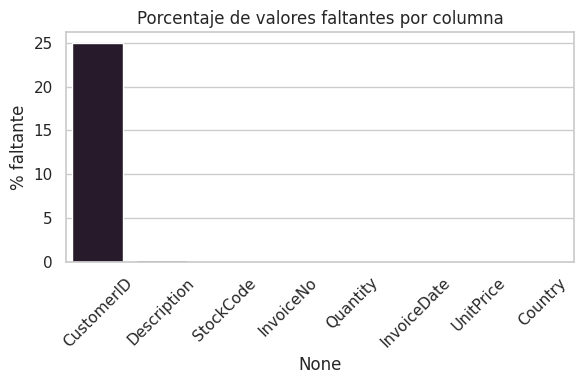

In [44]:
plt.figure(figsize=(6, 4))
sns.barplot(x=missing.index, y=missing['pct_missing'], palette='mako')
plt.xticks(rotation=45)
plt.ylabel('% faltante')
plt.title('Porcentaje de valores faltantes por columna')
plt.tight_layout()
plt.show()


/tmp/ipykernel_2859/2910708284.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


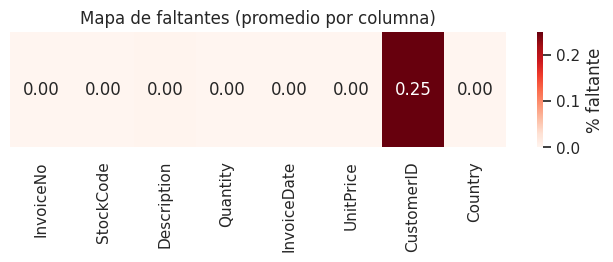

In [45]:
plt.figure(figsize=(8,1.5))
sns.heatmap(df_raw_pd.isna().mean().to_frame().T, cmap='Reds', cbar_kws={'label': '% faltante'}, annot=True, fmt='.2f')
plt.title('Mapa de faltantes (promedio por columna)')
plt.yticks([])
plt.tight_layout()
plt.show()


In [46]:
quality_checks = {
    "cancelaciones": df_raw_pd['InvoiceNo'].astype(str).str.startswith('C').sum(),
    "cantidades_no_positivas": (df_raw_pd['Quantity'] <= 0).sum(),
    "precios_no_positivos": (df_raw_pd['UnitPrice'] <= 0).sum(),
    "descripciones_vacias": df_raw_pd['Description'].isna().sum() + (df_raw_pd['Description'].astype(str).str.strip() == '').sum(),
    "duplicados_exactos": df_raw_pd.duplicated().sum(),
}
print("Chequeos de calidad (conteos):")
print(pd.DataFrame.from_dict(quality_checks, orient='index', columns=['conteo']))


Chequeos de calidad (conteos):
                         conteo
cancelaciones              9288
cantidades_no_positivas   10624
precios_no_positivos       2517
descripciones_vacias       1454
duplicados_exactos         5268


## Limpieza con pipeline (GPU opcional)
Pasos:
1. Eliminar cancelaciones (`InvoiceNo` que empieza con "C").
2. Mantener `Quantity` y `UnitPrice` positivos.
3. Quitar descripciones vacias/NA.
4. Convertir tipos y eliminar duplicados exactos.
5. Filtrar productos poco frecuentes (default: >=50 apariciones) para reducir sparsity.
6. Recortar outliers via IQR (se recorta, no se elimina fila) para estabilizar distribuciones.

Si `USE_GPU=True` y `cudf` disponible, la limpieza se ejecuta en GPU y luego se convierte a pandas para graficas.


In [47]:
def clip_iqr(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return series.clip(lower, upper)


def clean_retail(df, min_item_freq=50, use_gpu=False):
    log = []
    out = df.copy()
    out['InvoiceNo'] = out['InvoiceNo'].astype(str).str.strip()
    start_len = len(out)
    print(f"Inicio limpieza: {start_len:,} filas en {'GPU' if use_gpu else 'CPU'}")

    def log_step(name, before, after):
        removed = int(before - after)
        log.append({
            "paso": name,
            "filas_removidas": removed,
            "pct_inicial": removed / start_len * 100
        })
        print(f"- {name}: -{removed} filas ({removed / start_len * 100:.2f}% del total)")

    before = len(out)
    out = out[~out['InvoiceNo'].str.startswith('C')]
    log_step("Eliminar cancelaciones", before, len(out))

    before = len(out)
    out = out[(out['Quantity'] > 0) & (out['UnitPrice'] > 0)]
    log_step("Cantidad y precio positivos", before, len(out))

    out['Description'] = out['Description'].astype(str).str.strip()
    before = len(out)
    out = out[out['Description'] != ""]
    out = out.dropna(subset=['Description'])
    log_step("Descripciones vacias/NA", before, len(out))

    out['InvoiceDate'] = pd.to_datetime(out['InvoiceDate']) if not use_gpu else cudf.to_datetime(out['InvoiceDate'])
    out['Country'] = out['Country'].astype(str).str.strip()

    before = len(out)
    out = out.drop_duplicates()
    log_step("Duplicados exactos", before, len(out))

    counts = out['Description'].value_counts()
    keep_items = counts[counts >= min_item_freq].index
    before = len(out)
    out = out[out['Description'].isin(keep_items)]
    log_step(f"Items con freq >= {min_item_freq}", before, len(out))

    out['Quantity'] = clip_iqr(out['Quantity'])
    out['UnitPrice'] = clip_iqr(out['UnitPrice'])

    summary = {
        "filas_iniciales": int(start_len),
        "filas_finales": int(len(out)),
        "productos": int(out['Description'].nunique()),
        "facturas": int(out['InvoiceNo'].nunique()),
        "clientes": int(out['CustomerID'].nunique()),
        "rango_fechas": (out['InvoiceDate'].min(), out['InvoiceDate'].max())
    }

    return out, pd.DataFrame(log), summary


df_clean_gpu, log_df, summary = clean_retail(df_raw, min_item_freq=50, use_gpu=USE_GPU and cudf is not None)
df = df_clean_gpu.to_pandas() if (USE_GPU and cudf is not None) else df_clean_gpu
print("Resumen limpieza:")
print(log_df)
print("Resumen general:")
print(summary)
log_df


Inicio limpieza: 541,909 filas en CPU


- Eliminar cancelaciones: -9288 filas (1.71% del total)
- Cantidad y precio positivos: -2517 filas (0.46% del total)
- Descripciones vacias/NA: -0 filas (0.00% del total)
- Duplicados exactos: -5226 filas (0.96% del total)
- Items con freq >= 50: -30290 filas (5.59% del total)
Resumen limpieza:
                          paso  filas_removidas  pct_inicial
0       Eliminar cancelaciones             9288         1.71
1  Cantidad y precio positivos             2517         0.46
2      Descripciones vacias/NA                0         0.00
3           Duplicados exactos             5226         0.96
4         Items con freq >= 50            30290         5.59
Resumen general:
{'filas_iniciales': 541909, 'filas_finales': 494588, 'productos': 2190, 'facturas': 19748, 'clientes': 4321, 'rango_fechas': (Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))}


,paso,filas_removidas,pct_inicial
0,Eliminar cancelaciones,9288,1.71
1,Cantidad y precio positivos,2517,0.46
2,Descripciones vacias/NA,0,0.00
3,Duplicados exactos,5226,0.96
4,Items con freq >= 50,30290,5.59


In [48]:
pd.DataFrame([summary])


,filas_iniciales,filas_finales,productos,facturas,clientes,rango_fechas
0,541909,494588,2190,19748,4321,"(2010-12-01 08:26:00, 2011-12-09 12:50:00)"


## Distribuciones y outliers (recortados)


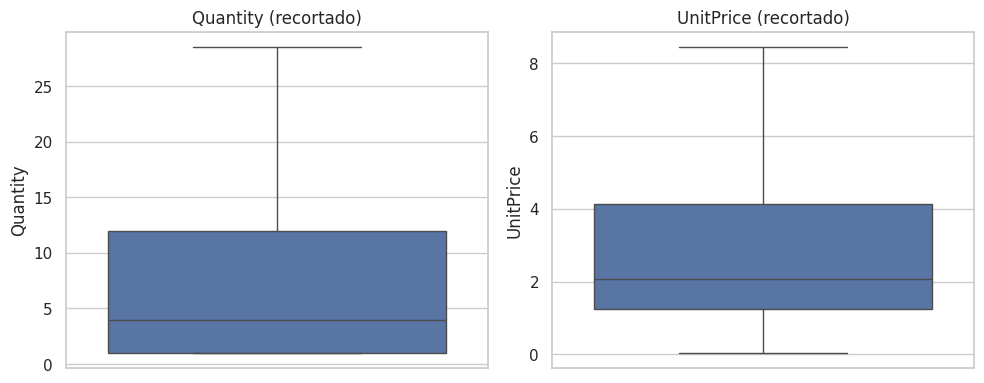

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.boxplot(y=df['Quantity'], ax=axes[0])
axes[0].set_title('Quantity (recortado)')
sns.boxplot(y=df['UnitPrice'], ax=axes[1])
axes[1].set_title('UnitPrice (recortado)')
plt.tight_layout()
plt.show()


## Estacionalidad de ventas (mensual)


/tmp/ipykernel_2859/422733066.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_qty = df.set_index('InvoiceDate').resample('M')['Quantity'].sum()


Variaciones mensuales (>25% absoluto):
             pct_change
InvoiceDate            
2011-03-31         0.35
2011-05-31         0.32
2011-09-30         0.44
2011-11-30         0.28
2011-12-31        -0.70


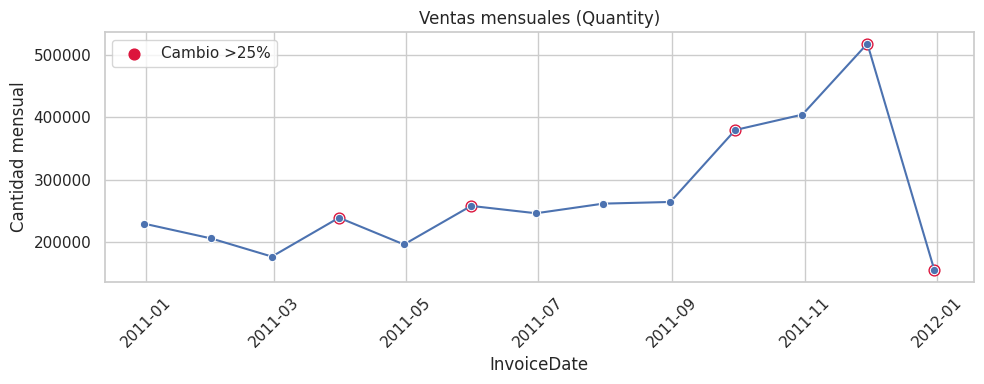

In [50]:
monthly_qty = df.set_index('InvoiceDate').resample('M')['Quantity'].sum()
changes = monthly_qty.pct_change()
spikes = changes[changes.abs() > 0.25]

print("Variaciones mensuales (>25% absoluto):")
print(spikes.to_frame(name='pct_change'))

plt.figure(figsize=(10, 4))
ax = sns.lineplot(x=monthly_qty.index, y=monthly_qty.values, marker='o')
plt.scatter(spikes.index, monthly_qty.loc[spikes.index], color='crimson', s=60, label='Cambio >25%')
plt.xticks(rotation=45)
plt.ylabel('Cantidad mensual')
plt.title('Ventas mensuales (Quantity)')
plt.legend()
plt.tight_layout()
plt.show()


## Top productos


Top 20 productos (conteo):
Description
WHITE HANGING HEART T-LIGHT HOLDER    2311
JUMBO BAG RED RETROSPOT               2109
REGENCY CAKESTAND 3 TIER              2007
PARTY BUNTING                         1699
LUNCH BAG RED RETROSPOT               1581
ASSORTED COLOUR BIRD ORNAMENT         1476
SET OF 3 CAKE TINS PANTRY DESIGN      1392
PACK OF 72 RETROSPOT CAKE CASES       1352
LUNCH BAG  BLACK SKULL.               1301
NATURAL SLATE HEART CHALKBOARD        1255
JUMBO BAG PINK POLKADOT               1232
HEART OF WICKER SMALL                 1219
JUMBO STORAGE BAG SUKI                1194
PAPER CHAIN KIT 50'S CHRISTMAS        1184
JUMBO SHOPPER VINTAGE RED PAISLEY     1180
LUNCH BAG SPACEBOY DESIGN             1164
JAM MAKING SET PRINTED                1164
LUNCH BAG CARS BLUE                   1162
SPOTTY BUNTING                        1154
JAM MAKING SET WITH JARS              1133
Name: count, dtype: int64


/tmp/ipykernel_2859/3302463798.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


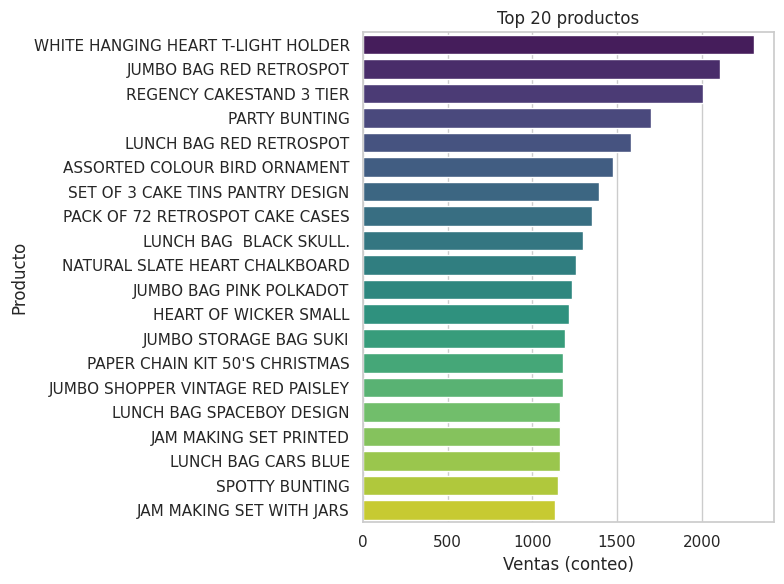

In [51]:
top_products = df['Description'].value_counts().head(20)
print("Top 20 productos (conteo):")
print(top_products)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.xlabel('Ventas (conteo)')
plt.ylabel('Producto')
plt.title('Top 20 productos')
plt.tight_layout()
plt.show()


## Canastas y tamanos de ticket


Transacciones: 19748 | Items unicos: 2190 | Ticket mediano: 15
InvoiceNo
536365    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
536366                             [HAND WARMER UNION JACK]
536367    [ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...
536368    [JAM MAKING SET WITH JARS, RED COAT RACK PARIS...
536369                           [BATH BUILDING BLOCK WORD]
Name: Description, dtype: object


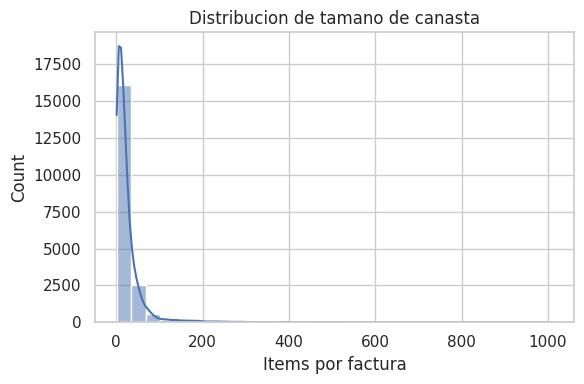

In [52]:
basket = df.groupby('InvoiceNo')['Description'].apply(list)
basket_size = basket.apply(len)
print(f"Transacciones: {len(basket)} | Items unicos: {df['Description'].nunique()} | Ticket mediano: {basket_size.median():.0f}")
print(basket.head())

plt.figure(figsize=(6,4))
sns.histplot(basket_size, bins=30, kde=True)
plt.xlabel('Items por factura')
plt.title('Distribucion de tamano de canasta')
plt.tight_layout()
plt.show()


## Guardar dataset procesado


In [53]:
PROCESSED_PATH.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(PROCESSED_PATH, index=False)
print(f"Guardado en {PROCESSED_PATH}")


Guardado en data/processed/cleaned_online_retail.csv
